## Name: Tay Yikoon Lomibao @ Tay Yi Koon
## Admission No.: 2309389
## Class: DAAA/1B/01

# Import Modules and Dataset

In [244]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from warnings import filterwarnings
os.chdir("C:\\Users\\obsid\\OneDrive\\Documents\\CA1-Dataset")

In [231]:
df2 = pd.read_csv('CA1-Regression-Dataset.csv', index_col="ID") # Load in dataset
df2.head()

,Age,Gender,BMI,Smoker,Region,Cost ($)
ID,,,,,,
1,19,female,27.900,yes,southwest,16884.92400
2,18,male,33.770,no,southeast,1725.55230
3,28,male,33.000,no,southeast,4449.46200
4,33,male,22.705,no,northwest,21984.47061
5,32,male,28.880,no,northwest,3866.85520


In [198]:
df2.shape # Print the dimensions of the dataset

(1338, 6)

# Explanation Of Features

1. Age: This provides the age of the person. According to National Institutes of Health, the highest hospital costs are around ages 18 to 25, and 40 onwards.

2. Gender: This provides whether the person is male or female. Healthcare may be utilised more by women because they are more likely than men to have chronic conditions, which can be expensive to treat.

3. BMI: The Body Mass Index (BMI) is the the person's weight in kilograms divided by the squared of the person's height in metres. People with higher BMI tend to have more expensive hospital costs, especially for the severely obese.

4. Smoker: This indicates whether the person regularly smokes cigarettes with values 'yes' and 'no'. According to Ministry Of Health, smoking has associated with at least 11 major medical conditions which accounted to $180 million in healthcare costs in 2019, so people who smoke may encounter more expensive medical costs.

5. Region: This provides the person's residential area with values 'southwest', 'southeast', 'northwest' and 'northeast'. Based on the background information, these regions are in the US. The top 3 US states with the most expensive healthcare are Massachusetts, Connecticut and New York, which are all in the north-east.

6. Cost ($): This is the hospital cost for the person which may be explained by the other features. Usually people with more severe health conditions are subject to more expensive hospital costs.

# Prediction Task

This can be defined by the background information which says this is a dataset to predict hospital costs in US hospitals based on various patient information. Therefore, the task is to ascertain the patterns between the features and the target (Cost ($)) and predict the hospital cost with minimal error.

# Data Exploration

In [127]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1338 entries, 1 to 1338
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Age       1338 non-null   int64  
 1   Gender    1338 non-null   object 
 2   BMI       1338 non-null   float64
 3   Smoker    1338 non-null   object 
 4   Region    1338 non-null   object 
 5   Cost ($)  1338 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 73.2+ KB


In [128]:
df2.describe()

,Age,BMI,Cost ($)
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


<Axes: ylabel='ID'>

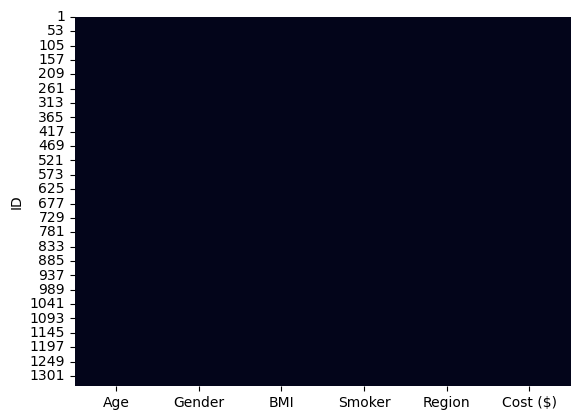

In [129]:
sns.heatmap(df2.isnull(), cbar=False) # Visualise the amount of missing values

In [130]:
df2.isna().sum()

Age         0
Gender      0
BMI         0
Smoker      0
Region      0
Cost ($)    0
dtype: int64

There are no missing values in this dataset.

<Axes: xlabel='Gender', ylabel='Cost ($)'>

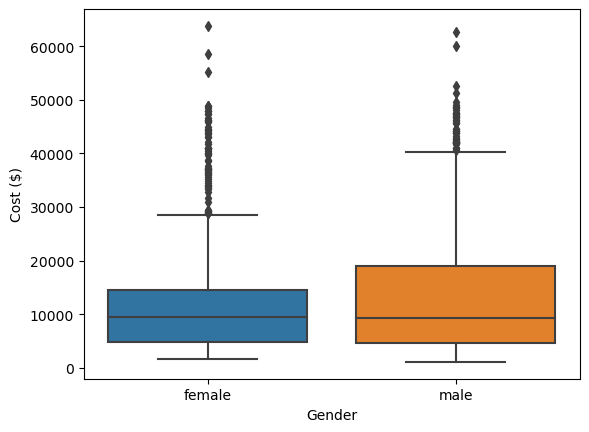

In [131]:
sns.boxplot(data = df2, x = "Gender", y = "Cost ($)") # Visualise the distribution between gender and cost

female has a smaller distribution than male where the maximum and upper quartile is smaller. However, female seems to have more outliers than male.

<Axes: xlabel='Smoker', ylabel='Cost ($)'>

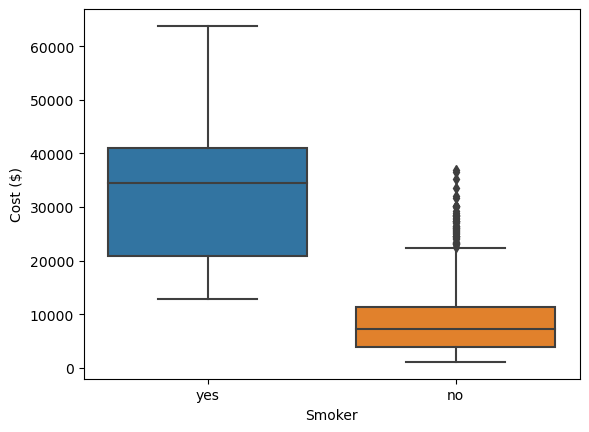

In [132]:
sns.boxplot(data = df2, x = "Smoker", y = "Cost ($)") # Visualise the distribution between smoking and cost

People who smoke generally have higher hospital costs as the median is higher than the maximum of non-smokers.

<Axes: xlabel='Region', ylabel='Cost ($)'>

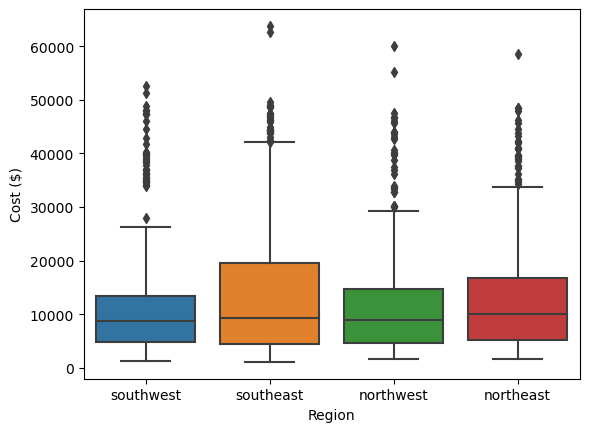

In [133]:
sns.boxplot(data = df2, x = "Region", y = "Cost ($)") # Visualise the distribution between region and cost

southwest seems to have the cheapest hospital costs as it has the shortest box plot and the upper quartile is shorter than the others.

<Axes: xlabel='Cost ($)'>

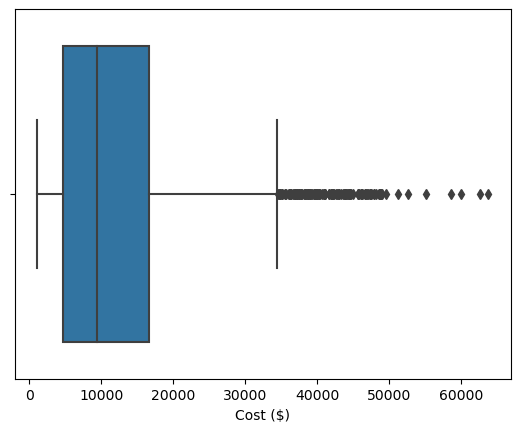

In [134]:
sns.boxplot(data=df2, x=df2["Cost ($)"]) # Visualise the distribution of cost

The distribution of cost is positively-skewed with median below $10k. It also appears to have a lot of outliers.

<Axes: xlabel='Age'>

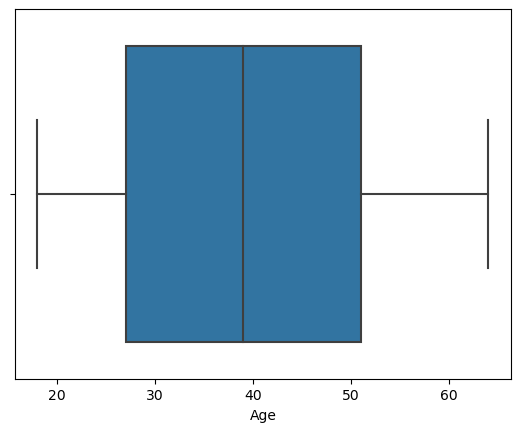

In [135]:
sns.boxplot(data=df2, x=df2["Age"])# Visualise the distribution of Age

Age seems to be quite evenly distributed, with a slight positive skewness with no outliers.

<Axes: xlabel='BMI'>

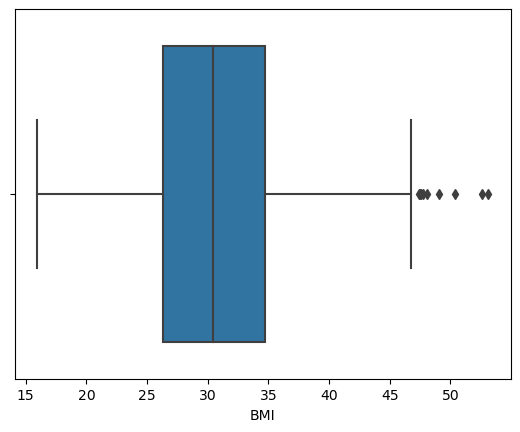

In [136]:
sns.boxplot(data=df2, x=df2["BMI"]) # Visualise the distribution of BMI

BMI is also slightly positively-skewed, but it has outliers, so I may have to remove them 

C:\Users\obsid\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


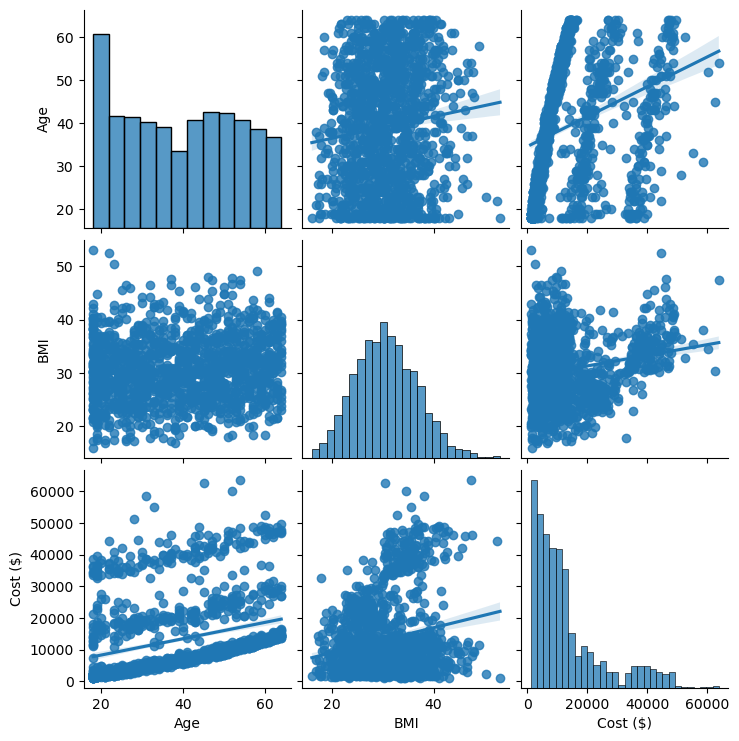

In [137]:
sns.pairplot(df2, kind='reg') # Plot scatterplot of each feature against the other 

Positive relationships can be identified in Age and BMI, Age and Cost and BMI and Cost.

In [232]:
df2["dummy_gender"] = 0 # Get dummy variables for categorical features gender and smoker
for i in range(0, len(df2)):
    if df2.iloc[i, 1] == 'male':
        df2.iloc[i, 6] = 1
    else:
        df2.iloc[i, 6] = 0
        
df2["dummy_smoker"] = 0
for i in range(0, len(df2)):
    if df2.iloc[i, 3] == 'yes':
        df2.iloc[i, 7] = 1
    else:
        df2.iloc[i, 7] = 0
        
df2["encoded_northeast"] = 0 # Perform one hot encoding on region
df2["encoded_northwest"] = 0
df2["encoded_southeast"] = 0
df2["encoded_southwest"] = 0

for i in range (0, len(df2)):
    if df2.iloc[i, 4] == 'northeast':
        df2.iloc[i, 8] = 1
    elif df2.iloc[i, 4] == 'northwest':
        df2.iloc[i, 9] = 1
    elif df2.iloc[i, 4] == 'southeast':
        df2.iloc[i, 10] = 1
    else: df2.iloc[i, 11] = 1

df2.head()

,Age,Gender,BMI,Smoker,Region,Cost ($),dummy_gender,dummy_smoker,encoded_northeast,encoded_northwest,encoded_southeast,encoded_southwest
ID,,,,,,,,,,,,
1,19,female,27.900,yes,southwest,16884.92400,0,1,0,0,0,1
2,18,male,33.770,no,southeast,1725.55230,1,0,0,0,1,0
3,28,male,33.000,no,southeast,4449.46200,1,0,0,0,1,0
4,33,male,22.705,no,northwest,21984.47061,1,0,0,1,0,0
5,32,male,28.880,no,northwest,3866.85520,1,0,0,1,0,0


Since there are categorical values (Gender, Smoker and Region), I decided to use one hot encoding to get dummy variables for the region feature so to not confuse the model and take higher numbers as more important. Therefore, each region can still be classified as 0 or 1.

In [233]:
df2.drop(["Gender", "Smoker", "Region"], axis=1, inplace=True) # Drop the original categorical features

df2.head()

,Age,BMI,Cost ($),dummy_gender,dummy_smoker,encoded_northeast,encoded_northwest,encoded_southeast,encoded_southwest
ID,,,,,,,,,
1,19,27.900,16884.92400,0,1,0,0,0,1
2,18,33.770,1725.55230,1,0,0,0,1,0
3,28,33.000,4449.46200,1,0,0,0,1,0
4,33,22.705,21984.47061,1,0,0,1,0,0
5,32,28.880,3866.85520,1,0,0,1,0,0


In [201]:
df2.corr()['Cost ($)']

Age                  0.299008
BMI                  0.198341
Cost ($)             1.000000
dummy_gender         0.057292
dummy_smoker         0.787251
encoded_northeast    0.006349
encoded_northwest   -0.039905
encoded_southeast    0.073982
encoded_southwest   -0.043210
Name: Cost ($), dtype: float64

<Axes: >

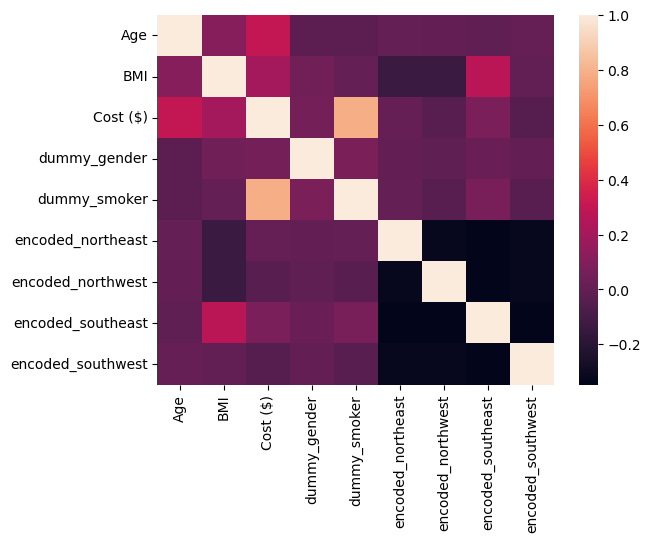

In [19]:
sns.heatmap(df2.corr())

Looking at the correlation between the features, the strongest positive correlation is between smoker and cost. Both age and BMI have weak positive correlations with cost. BMI and Age also have a weak positive correlation.

# Data Preprocessing

In [234]:
df2_filtered = df2

features = ['BMI', 'Cost ($)']

for feature in features: # Filter out outliers in BMI and cost
   Q1 = df2_filtered[feature].quantile(0.25)
   Q3 = df2_filtered[feature].quantile(0.75)
   IQR = Q3 - Q1
   df2_filtered = df2_filtered[(df2_filtered[feature] >= Q1 - 1.5 * IQR) & (df2_filtered[feature] <= Q3 + 1.5 * IQR)]

print(df2_filtered.shape)

(1191, 9)


About 147 instances of data was removed by filtering out outliers

In [235]:
X = df2_filtered.drop(columns="Cost ($)")
y = df2_filtered["Cost ($)"]

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Perform train test split on inliers
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Create validation from training data

scaler = StandardScaler()
# Do scaling to normalise the features and ensure no feature overpowers the other and influence the model too greatly

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
X_val_scaled = scaler.fit_transform(X_val.values)
y_val_scaled = scaler.fit_transform(y_val.values.reshape(-1, 1))

I scaled all of my train, test and validation values to make the mean 0 and standard deviation 1 to make it easier for the model to work with using StandardScaler.

# Regularisation and Feature Selection

In [237]:
alphas = [0.01, 0.1, 0.4, 0.5, 0.6, 0.8, 1] # Set a range of alphas to find out which alpha performs the best
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Do K-Fold to reduce over-fitting
lasso_cv = LassoCV(alphas = alphas, cv=kf, random_state=42) # Do LassoCV to regularise the data and look at coefficients
lasso_cv.fit(X_train_scaled, y_train_scaled)
y_pred_lasso = lasso_cv.predict(X_val_scaled)
mse_lasso = mean_squared_error(y_val_scaled, y_pred_lasso) # Calculate performance of Lasso
r2_lasso = r2_score(y_val_scaled, y_pred_lasso)
print(f"Lasso CV - Best Alpha: {lasso_cv.alpha_}, MSE: {mse_lasso:.2f}, R2: {r2_lasso:.2f}")
print(f"Intercept: {lasso_cv.intercept_}")
print(f"Coefficients: {lasso_cv.coef_}")

Lasso CV - Best Alpha: 0.01, MSE: 0.33, R2: 0.67
Intercept: 8.296437103682047e-17
Coefficients: [ 0.46138751  0.03280385 -0.          0.62716574  0.01290318  0.01233263
 -0.01000448 -0.01838399]


I am using Lasso to perform regularisation, as it will minimise the adjusted loss function and helps prevent overfitting or underfitting. I am also using Lasso to perform feature selection, as its coefficients can tell what features are not important in the dataset. It seems that there is a feature that is not considered important, let's find out which feature this is.

In [238]:
X.head() # Identify which feature is not important

,Age,BMI,dummy_gender,dummy_smoker,encoded_northeast,encoded_northwest,encoded_southeast,encoded_southwest
ID,,,,,,,,
1,19,27.900,0,1,0,0,0,1
2,18,33.770,1,0,0,0,1,0
3,28,33.000,1,0,0,0,1,0
4,33,22.705,1,0,0,1,0,0
5,32,28.880,1,0,0,1,0,0


Lasso does not consider dummy_gender important, so I will drop this column

In [239]:
X = X.drop(columns="dummy_gender") # Drop unimportant column
# Redo train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler() # redo scaling

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
X_val_scaled = scaler.fit_transform(X_val.values)
y_val_scaled = scaler.fit_transform(y_val.values.reshape(-1, 1))

In [240]:
lasso_reg = Lasso(alpha=0.01, random_state=42) # Redo regularisation but with best alpha
lasso_reg.fit(X_train_scaled, y_train_scaled)
y_pred_lasso = lasso_reg.predict(X_val_scaled)
mse_lasso = mean_squared_error(y_val_scaled, y_pred_lasso) # Calculate performance of Lasso
r2_lasso = r2_score(y_val_scaled, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_val_scaled, y_pred_lasso)
print(f"MSE: {mse_lasso:.2f}, R2: {r2_lasso:.2f}, MAPE: {mape_lasso:.2f}")
print(f"Intercept: {lasso_cv.intercept_}")

MSE: 0.33, R2: 0.67, MAPE: 1.04
Intercept: 8.296437103682047e-17


## Model Evaluation Quality

I will be evaluating the quality of my model by using:
1. Mean Absolute Percentage Error: Percentage difference between predicted and actual values (Lower is better)
2. Mean Squared Error: Average squared difference between actual and predicted values (Lower is better)
3. R-Squared: Indicates how well the independent variable explains the variability of the dependent variable (Higher is better)

# Dummy Baseline Model Without Outliers

In [211]:
DR_baseline = DummyRegressor() # Using Dummy Regressor as my dummy baseline model

DR_baseline.fit(X_train_scaled, y_train_scaled)

y_pred_baseline = DC_baseline.predict(X_test_scaled)

DR_mape_baseline = round(mean_absolute_percentage_error(y_test_scaled, y_pred_baseline),2)
DR_mse_baseline = mean_squared_error(y_test_scaled, y_pred_baseline)
DR_r2_baseline = round(r2_score(y_test_scaled, y_pred_baseline),2)

print(f'The model Mean Absolute Percentage Error: {DR_mape_baseline:.2f}')
print(f'The model Mean Squared Error: {DR_mse_baseline:.2f}')
print(f'The model R-squared: {DR_r2_baseline:.2f}')

The model Mean Absolute Percentage Error: 1.00
The model Mean Squared Error: 1.00
The model R-squared: 0.00


These results seem simplistic with both MAPE and MSE being 1 and r2 being 0.

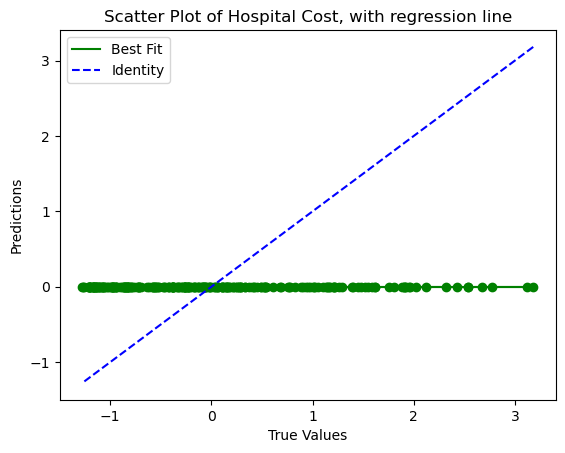

In [210]:
plt.scatter(x=y_test_scaled, y=y_pred_baseline, color='g') # Plot scatter plot with regression line
a, b = np.polyfit(y_test_scaled[:,0], y_pred_baseline, 1)
plt.plot(y_test_scaled, a * y_test_scaled + b, "g-", label="Best Fit")
p1 = max(max(y_pred_baseline), max(y_test_scaled))
p2 = min(min(y_pred_baseline), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], "b--", label="Identity")
plt.title('Scatter Plot of Hospital Cost, with regression line')
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.legend()
plt.show()

The best fit line does not follow the identity line at all, which means the trend of the identity is not being followed at all.

# K-Fold Cross Validation

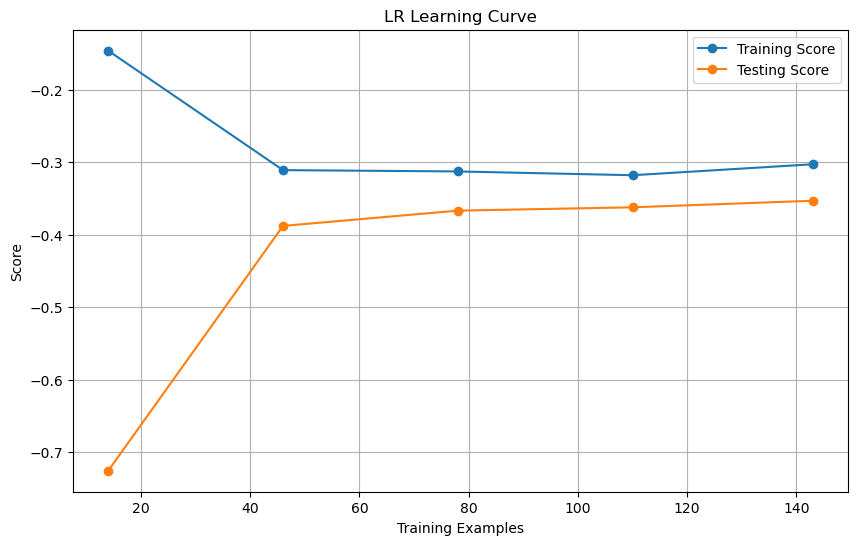

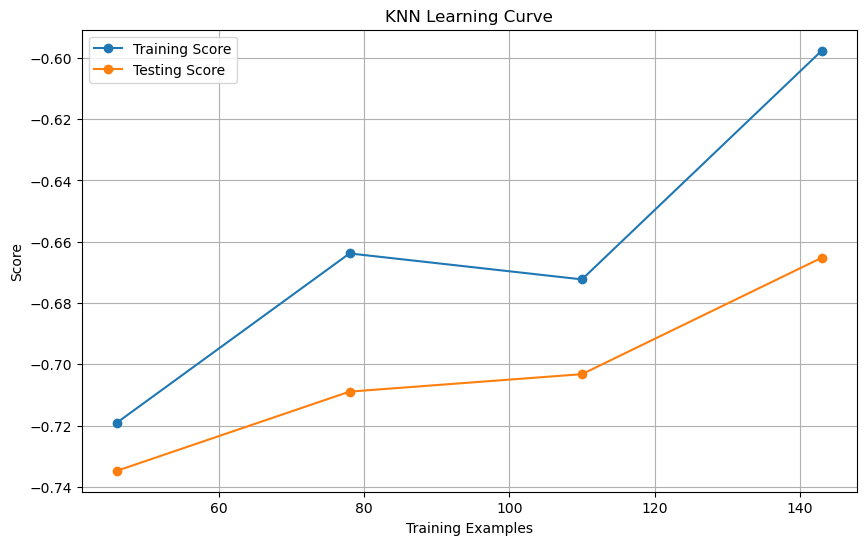

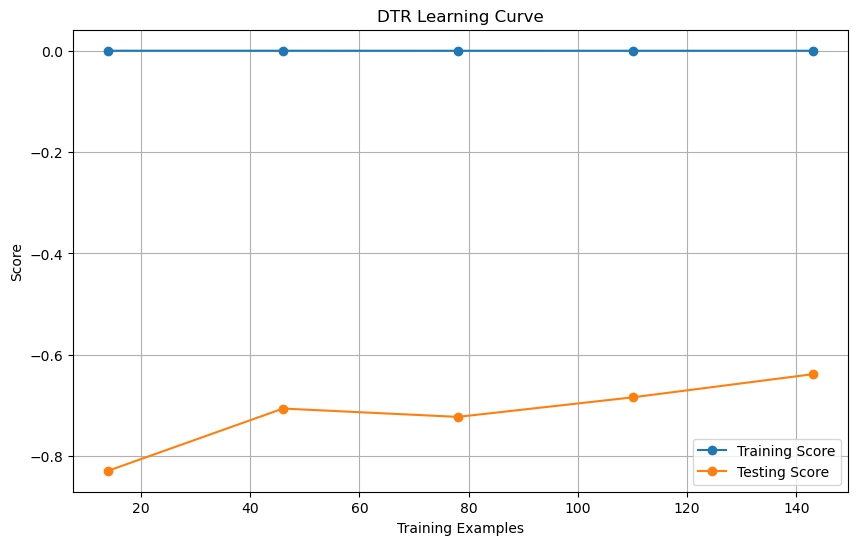

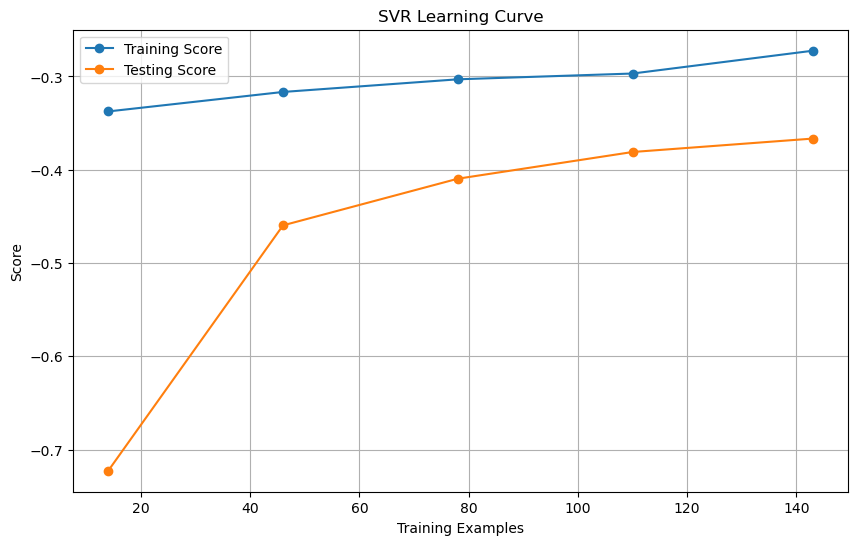

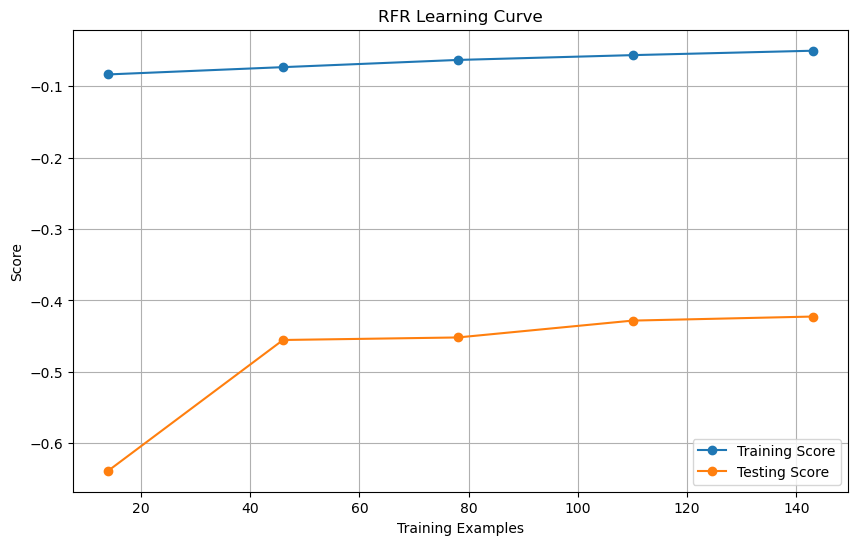

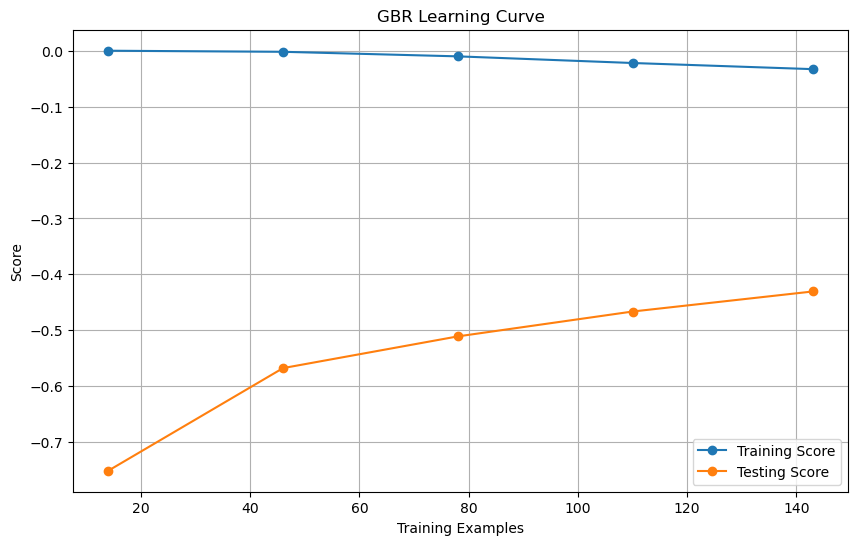

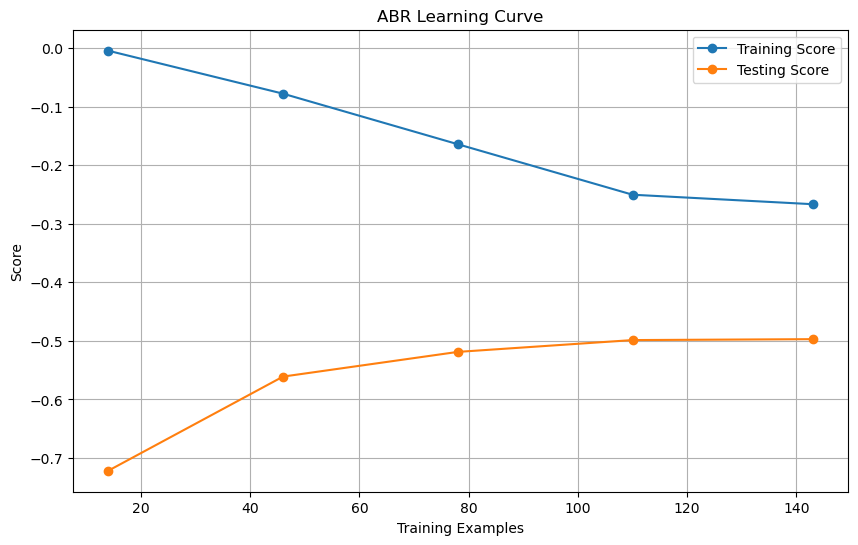

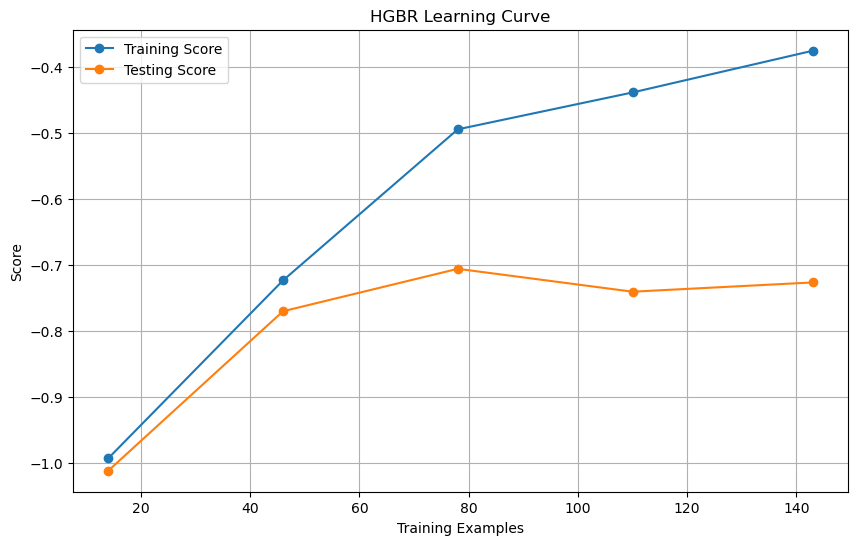

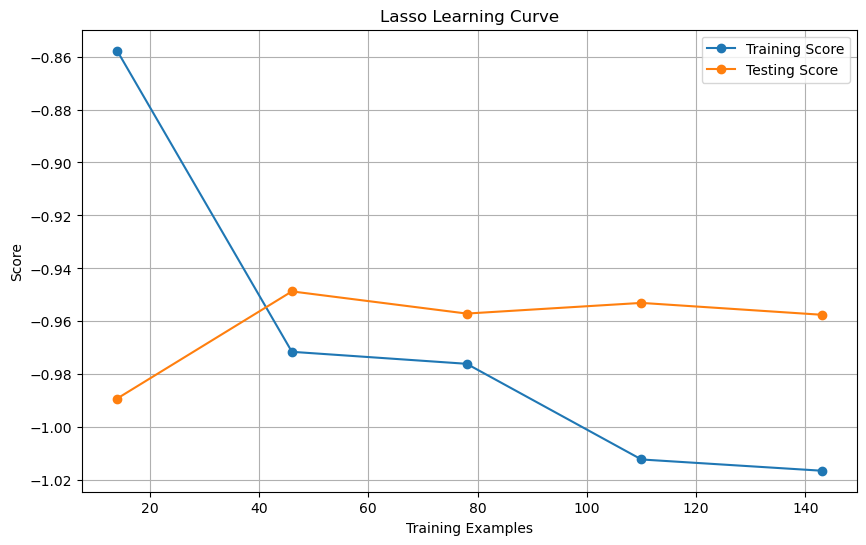

[('LR', -0.44), ('KNN', -0.49), ('DTR', -0.94), ('SVR', -0.46), ('RFR', -0.53), ('GBR', -0.46), ('ABR', -0.64), ('HGBR', -0.51), ('Lasso', -1.0)]


In [242]:
cross_val_results = [] # Perform K-Fold Cross Validation to select best models to tune
filterwarnings('ignore')

models = [('LR', LinearRegression()), ('KNN', KNeighborsRegressor(n_neighbors=23)), 
          ('DTR', DecisionTreeRegressor()), ('SVR', SVR()), ('RFR', RandomForestRegressor()), 
          ('GBR', GradientBoostingRegressor()), ('ABR', AdaBoostRegressor()), ('HGBR', HistGradientBoostingRegressor()),
          ('Lasso', Lasso())] # Instate the models to be used for cross validation

for name, model in models: # Perform cross validation for each model
    score = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kf, 
                            scoring='neg_mean_squared_error') # I'll be using neg_mean_squared_error as my scoring metric
    score = round(score.mean(), 2)
    cross_val_results.append((name, score))
    train_sizes, train_scores, test_scores = learning_curve( # Making scores for learning curve
    model, X_val_scaled, y_val_scaled, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=42),
                                                        scoring='neg_mean_squared_error'
                                                    )
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Testing Score')

    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

print(cross_val_results) # Also print cross validation scores

I selected these regression models from my lecturer's previous lessons and from online where I searched for more regression models that are used in sklearn. Out of all the scores where the greater value means more accurate, Linear Regression, Support Vector Regressor and GradientBoostingRegressor performed the best and these will be used for hyperparameter tuning. The learning curve shows the model's performance changing over training sizes. I used learning curve to check if the models are underfitting.

# Hyperparameter Tuning

In [164]:
LR_tuning = LinearRegression() # Identify the hyperparameters in LR

print('Hyperparameters in LR:\n', LR_tuning.get_params())

Hyperparameters in LR:
 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


In [165]:
LR_param_grid = {'copy_X': [True, False], # Create parameter grid to perform randomised grid search on
                 'fit_intercept': [True, False],
                 'n_jobs': [None, 1, 2, 4]
                }

# Perform randomised grid search
LR_random = RandomizedSearchCV(estimator=LR_tuning, param_distributions=LR_param_grid, n_iter=10, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

LR_random.fit(X_train_scaled, y_train_scaled)

LR_best_model = LR_random.best_estimator_ # Get the model with best parameters

y_val_pred = LR_best_model.predict(X_val_scaled) # Predict based on validation set

linear_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2
linear_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
linear_r2_val = round(r2_score(y_val_scaled, y_val_pred),2)

print(f'The model Mean Absolute Percentage Error: {linear_mape_val}')
print(f'The model Mean Squared Error: {linear_mse_val}')
print(f'The model R-squared: {linear_r2_val}')
print(f'Best parameters for LR: {LR_random.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The model Mean Absolute Percentage Error: 1.01
The model Mean Squared Error: 0.32
The model R-squared: 0.68
Best parameters for LR: {'n_jobs': None, 'fit_intercept': True, 'copy_X': True}


In [166]:
SVR_tuning = SVR() # Identify the hyperparameters in SVR

print('Hyperparameters in SVR:\n', SVR_tuning.get_params())

Hyperparameters in SVR:
 {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [167]:
SVR_param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Create parameter grid to perform randomised grid search on
                  'C': [0.1, 1, 10, 100], 
                  'gamma': ['scale', 'auto', 0.1, 1, 10],
                  'degree': [2, 3, 4],
                  'epsilon': [0.1, 0.2, 0.5, 1.0]
                 }

# Perform randomised grid search
SVR_random = RandomizedSearchCV(estimator=SVR_tuning, param_distributions=SVR_param_grid, n_iter=9, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

SVR_random.fit(X_train_scaled, y_train_scaled)

SVR_best_model = SVR_random.best_estimator_ # Get the model with best parameters

y_val_pred = SVR_best_model.predict(X_val_scaled) # Predict based on validation set

SVR_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2
SVR_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
SVR_r2_val = round(r2_score(y_val_scaled, y_val_pred),2)

print(f'The model Mean Absolute Percentage Error: {SVR_mape_val}')
print(f'The model Mean Squared Error: {SVR_mse_val}')
print(f'The model R-squared: {SVR_r2_val}')
print(f'Best parameters for SVR: {SVR_random.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The model Mean Absolute Percentage Error: 0.74
The model Mean Squared Error: 0.32
The model R-squared: 0.68
Best parameters for SVR: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.2, 'degree': 2, 'C': 1}


In [169]:
GBR_tuning = GradientBoostingRegressor() # Identify the hyperparameters in GBR
print('Hyperparameters in GBR:\n', GBR_tuning.get_params())

Hyperparameters in GBR:
 {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [170]:
GBR_param_grid = {'n_estimators': [50, 100, 200, 300], # Create parameter grid to perform randomised grid search on
                  'learning_rate': [0.01, 0.1, 0.2], 
                  'max_depth': [3, 4, 5, 6],    
                  'min_samples_split': [2, 5, 10],        
                  'min_samples_leaf': [1, 2, 4],      
                  'subsample': [0.8, 0.9, 1.0]
                 }

# Perform randomised grid search
GBR_random = RandomizedSearchCV(estimator=GBR_tuning, param_distributions=GBR_param_grid, n_iter=9, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

GBR_random.fit(X_train_scaled, y_train_scaled)

GBR_best_model = GBR_random.best_estimator_ # Get the model with best parameters

y_val_pred = GBR_best_model.predict(X_val_scaled) # Predict based on validation set

GBR_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2
GBR_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
GBR_r2_val = round(r2_score(y_val_scaled, y_val_pred),2)

print(f'The model Mean Absolute Percentage Error: {GBR_mape_val}')
print(f'The model Mean Squared Error: {GBR_mse_val}')
print(f'The model R-squared: {GBR_r2_val}')
print(f'Best parameters for GBR: {GBR_random.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The model Mean Absolute Percentage Error: 1.12
The model Mean Squared Error: 0.29
The model R-squared: 0.71
Best parameters for GBR: {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.2}


Out of all the models that have been hyperparameter tuned, Support Vector Regression performed the best when tested on validation set.

# Final Model WIthout Outliers and Evaluation

In [176]:
final_SVR = SVR(kernel = 'rbf', gamma = 0.1, epsilon = 0.2, degree = 2, C = 1) # Using SVR as final model

final_SVR.fit(X_train_scaled, y_train_scaled)

y_pred = final_SVR.predict(X_test_scaled) # Predict using test data

SVR_mape = round(mean_absolute_percentage_error(y_test_scaled, y_pred),2)
SVR_mse = round(mean_squared_error(y_test_scaled, y_pred),2)
SVR_r2 = round(r2_score(y_test_scaled, y_pred),2)

print(f'The model Mean Absolute Percentage Error: {SVR_mape}')
print(f'The model Mean Squared Error: {SVR_mse}')
print(f'The model R-squared: {SVR_r2}')

# Use permutation importance to get feature importances from SVR
result = permutation_importance(final_SVR, X_test_scaled, y_test_scaled, n_repeats=10, random_state=42)

feature_importances = result.importances_mean # Get feature importances

# Map feature importances to their corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Print feature importances
print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.4f}")

The model Mean Absolute Percentage Error: 0.92
The model Mean Squared Error: 0.37
The model R-squared: 0.63
Feature Importances:
Age: 0.4950
BMI: 0.0115
dummy_smoker: 0.8134
encoded_northeast: 0.0250
encoded_northwest: 0.0109
encoded_southeast: 0.0099
encoded_southwest: 0.0073


Compared to the baseline model, the final model performed much better, with all the scores improving. Overall, the final model had learnt the patterns in the data, and performed better as a result. I used permutation importance to get the feature importances from SVR where values that are greater is more important. The feature importances tell me that dummy_smoker played the most importance while encoded_southwest played the least.

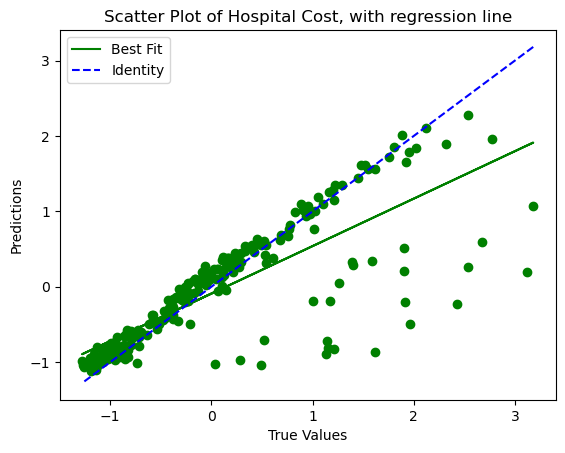

In [173]:
plt.scatter(x=y_test_scaled, y=y_pred, color='g') # Plot scatter plot with regression line
a, b = np.polyfit(y_test_scaled[:,0], y_pred, 1)
plt.plot(y_test_scaled, a * y_test_scaled + b, "g-", label="Best Fit")
p1 = max(max(y_pred), max(y_test_scaled))
p2 = min(min(y_pred), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], "b--", label="Identity")
plt.title('Scatter Plot of Hospital Cost, with regression line')
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.legend()
plt.show()

It performed better than the baseline plot, with the best fit more closely following the identity, capturing the trend better.

# With Outliers

# Data Preprocessing

In [213]:
X = df2.drop(columns="Cost ($)") # Set X and y with whole dataset
y = df2["Cost ($)"]

In [214]:
# Do train test split but with outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create validation set from training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler() # Perform scaling to normalise data

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
X_val_scaled = scaler.fit_transform(X_val.values)
y_val_scaled = scaler.fit_transform(y_val.values.reshape(-1, 1))

# Regularisation and Feature Selection

In [215]:
alphas = [0.01, 0.1, 0.4, 0.5, 0.6, 0.8, 1] # Set the range of alphas to see which alpha performs the best
kf = KFold(n_splits=5, shuffle=True, random_state=42) # Instate K-Fold to perform K-Fold Cross Validation for LassoCV
lasso_cv = LassoCV(alphas = alphas, cv=kf, random_state=42) # Using LassoCV to regularise and print coefficients
lasso_cv.fit(X_train_scaled, y_train_scaled)
y_pred_lasso = lasso_cv.predict(X_val_scaled) # Get scores of the model
mse_lasso = mean_squared_error(y_val_scaled, y_pred_lasso)
r2_lasso = r2_score(y_val_scaled, y_pred_lasso)
print(f"Lasso CV - Best Alpha: {lasso_cv.alpha_}, MSE: {mse_lasso:.2f}, R2: {r2_lasso:.2f}")
print(f"Intercept: {lasso_cv.intercept_}")
print(f"Coefficients: {lasso_cv.coef_}")

Lasso CV - Best Alpha: 0.01, MSE: 0.27, R2: 0.73
Intercept: -8.795536792944339e-17
Coefficients: [ 0.29466186  0.16481664 -0.          0.79586434  0.00741249  0.
 -0.         -0.00148417]


It seems that dummy_gender, encoded_northwest and encoded_southeast are not that important in the model, so I will be dropping them.

In [216]:
X.head()

,Age,BMI,dummy_gender,dummy_smoker,encoded_northeast,encoded_northwest,encoded_southeast,encoded_southwest
ID,,,,,,,,
1,19,27.900,0,1,0,0,0,1
2,18,33.770,1,0,0,0,1,0
3,28,33.000,1,0,0,0,1,0
4,33,22.705,1,0,0,1,0,0
5,32,28.880,1,0,0,1,0,0


In [217]:
X = X.drop(columns=["dummy_gender", "encoded_northwest", "encoded_southeast"]) # Drop unimportant columns
# Redo train test split but without unimportant columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler() # Redo scaling

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
X_val_scaled = scaler.fit_transform(X_val.values)
y_val_scaled = scaler.fit_transform(y_val.values.reshape(-1, 1))

In [218]:
lasso_reg = Lasso(alpha=0.01) # Redo regularisation but with best alpha
lasso_reg.fit(X_train_scaled, y_train_scaled)
y_pred_lasso = lasso_reg.predict(X_val_scaled) # Get scores of the model
mse_lasso = mean_squared_error(y_val_scaled, y_pred_lasso)
r2_lasso = r2_score(y_val_scaled, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_val_scaled, y_pred_lasso)
print(f"MSE: {mse_lasso:.2f}, R2: {r2_lasso:.2f}, MAPE: {mape_lasso:.2f}")

MSE: 0.27, R2: 0.73, MAPE: 2.03


# Dummy Baseline Model With Outliers

In [225]:
DR_baseline = DummyRegressor() # Using Dummy Regressor as my baseline model

DR_baseline.fit(X_train_scaled, y_train_scaled)

y_pred_baseline = DR_baseline.predict(X_test_scaled)

DR_mape_baseline = round(mean_absolute_percentage_error(y_test_scaled, y_pred_baseline),2)
DR_mse_baseline = round(mean_squared_error(y_test_scaled, y_pred_baseline),2)
DR_r2_baseline = round(r2_score(y_test_scaled, y_pred_baseline),2)

print(f'The model Mean Absolute Percentage Error: {DR_mape_baseline:.2f}')
print(f'The model Mean Squared Error: {DR_mse_baseline:.2f}')
print(f'The model R-squared: {DR_r2_baseline:.2f}')

The model Mean Absolute Percentage Error: 1.00
The model Mean Squared Error: 1.00
The model R-squared: 0.00


The dummy baseline results are the same as the baseline without outliers.

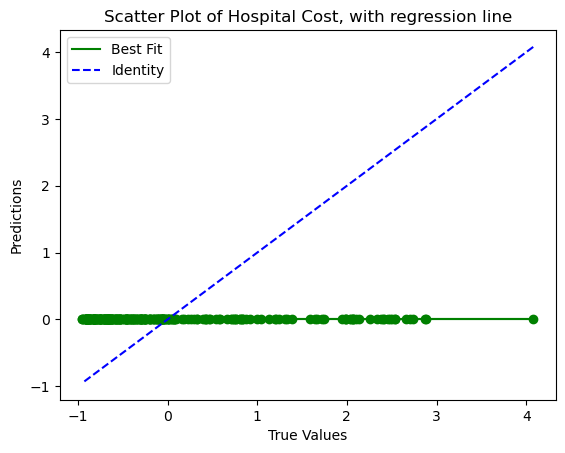

In [223]:
plt.scatter(x=y_test_scaled, y=y_pred_baseline, color='g') # Plot scatter plot with regression line
a, b = np.polyfit(y_test_scaled[:,0], y_pred_baseline, 1)
plt.plot(y_test_scaled, a * y_test_scaled + b, "g-", label="Best Fit")
p1 = max(max(y_pred_baseline), max(y_test_scaled))
p2 = min(min(y_pred_baseline), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], "b--", label="Identity")
plt.title('Scatter Plot of Hospital Cost, with regression line')
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.legend()
plt.show()

Shows the same results as the baseline without outliers.

# K-Fold Cross Validation

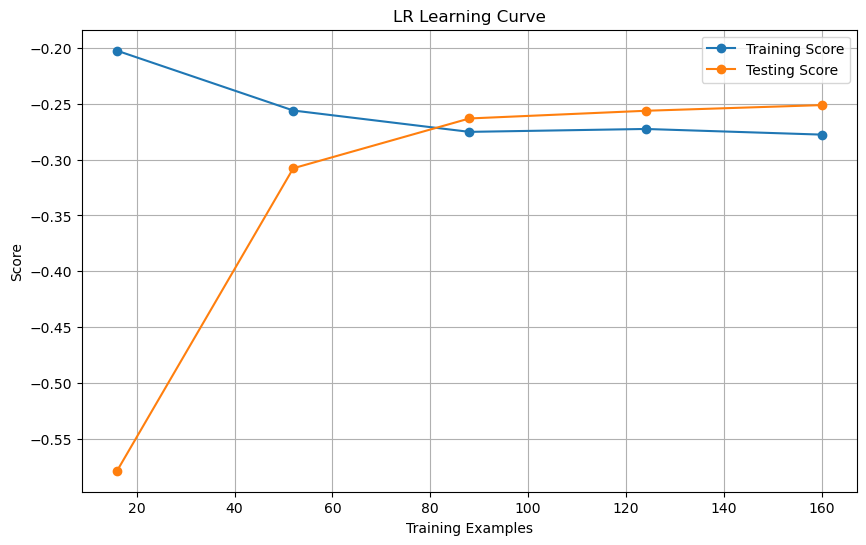

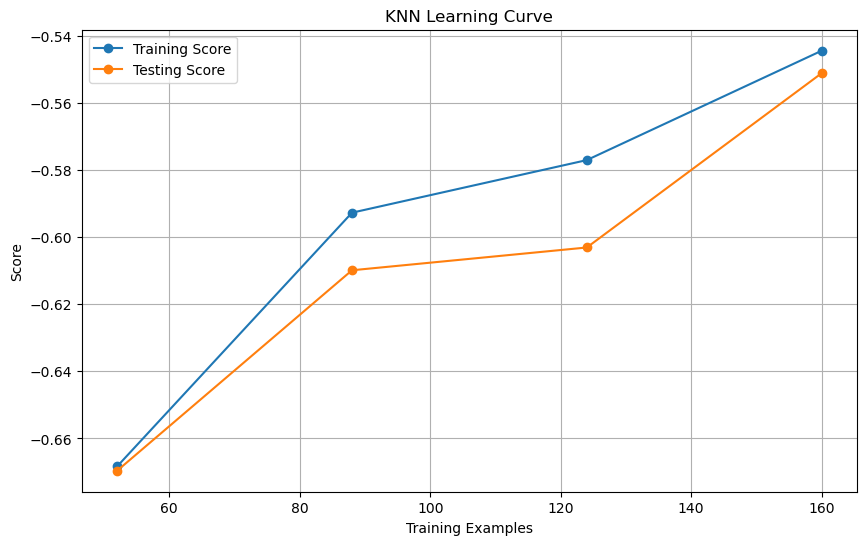

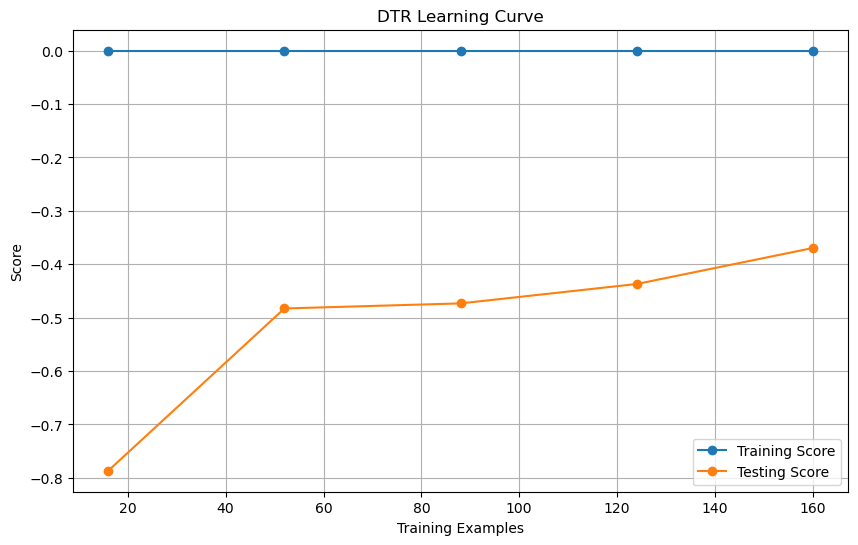

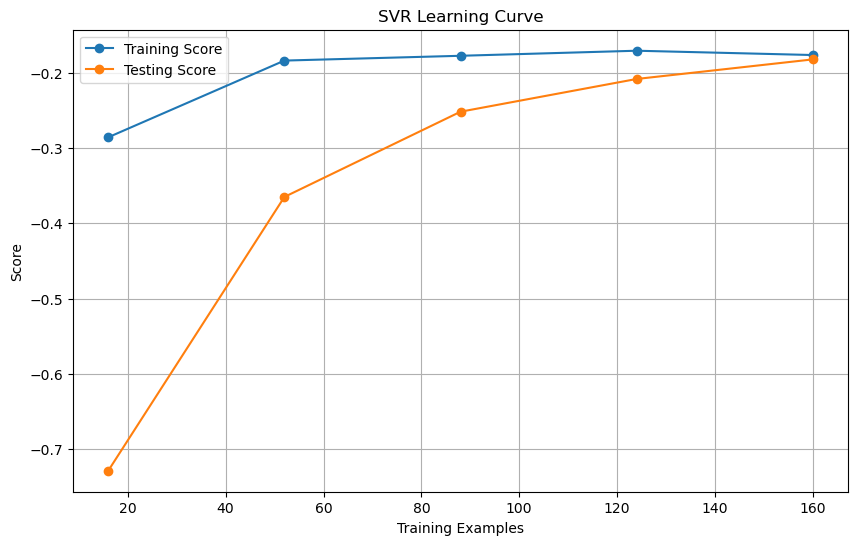

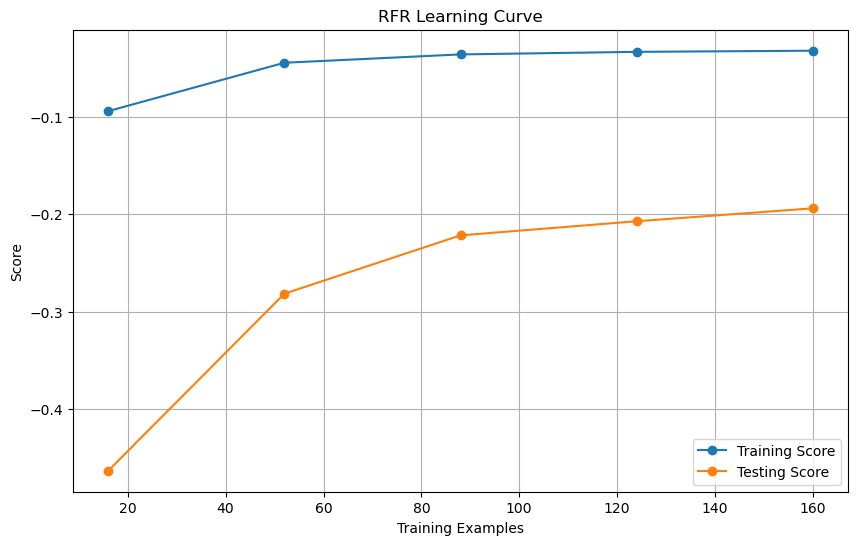

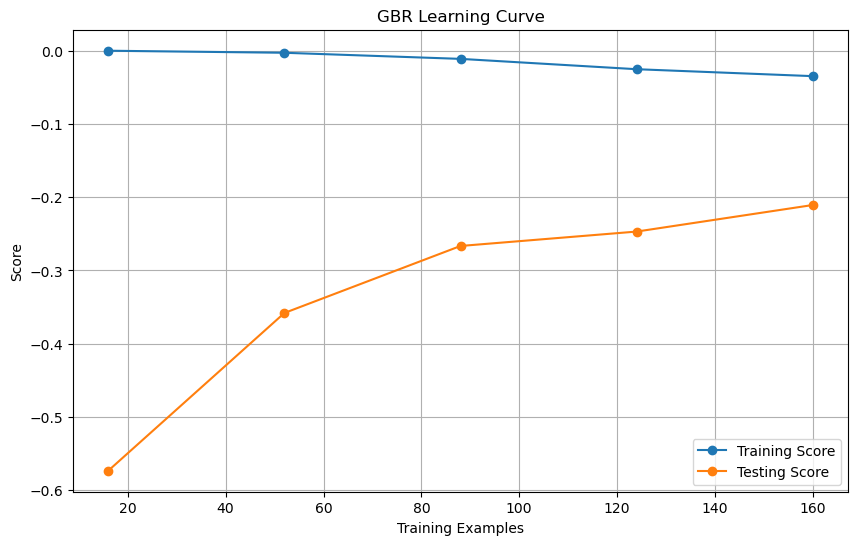

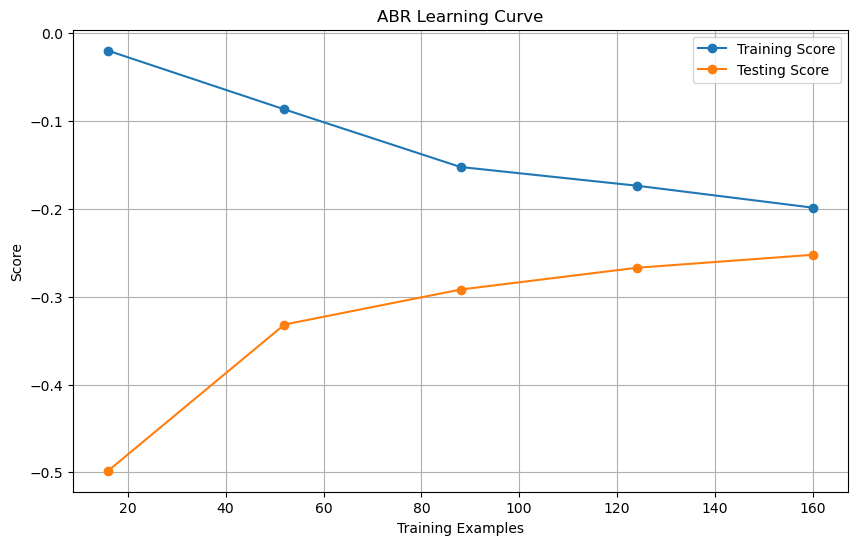

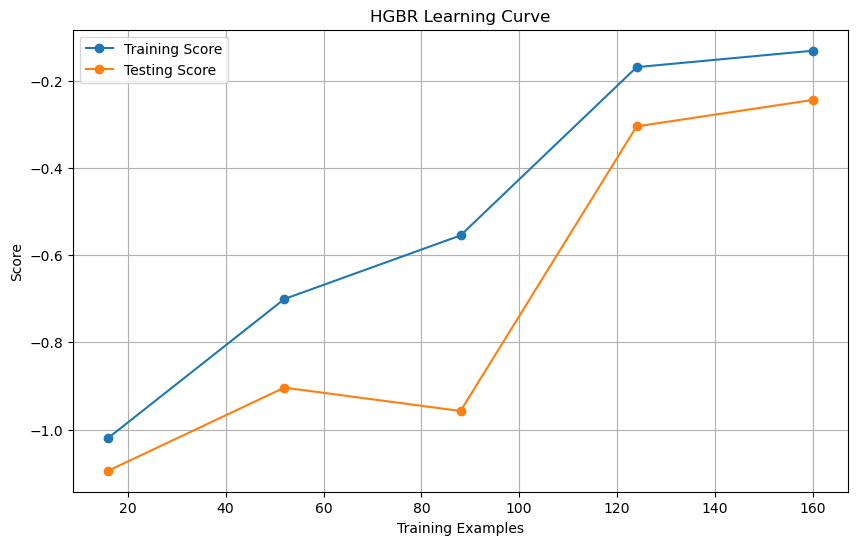

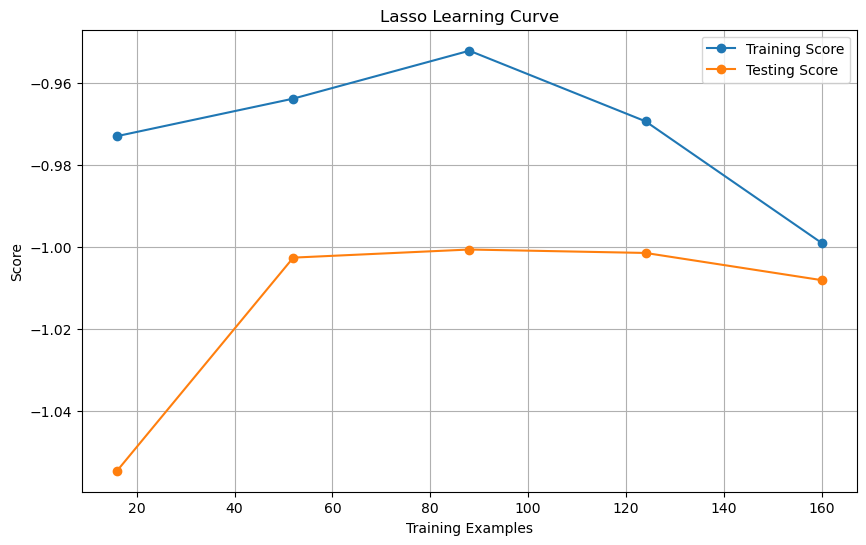

[('LR', -0.26), ('KNN', -0.29), ('DTR', -0.27), ('SVR', -0.17), ('RFR', -0.16), ('GBR', -0.14), ('ABR', -0.17), ('HGBR', -0.15), ('Lasso', -1.01)]


In [356]:
cross_val_results = [] # Perform K-Fold Cross Validation to select best models to tune
filterwarnings('ignore')

models = [('LR', LinearRegression()), ('KNN', KNeighborsRegressor(n_neighbors=23)), 
          ('DTR', DecisionTreeRegressor()), ('SVR', SVR()), ('RFR', RandomForestRegressor()), 
          ('GBR', GradientBoostingRegressor()), ('ABR', AdaBoostRegressor()), ('HGBR', HistGradientBoostingRegressor()),
          ('Lasso', Lasso())] # Instate different models to do cross validation

for name, model in models:
    score = cross_val_score(model, X_train_scaled, y_train_scaled, cv=kf, 
                            scoring='neg_mean_squared_error') # using neg_mean_squared_error to score
    score = round(score.mean(), 2)
    cross_val_results.append((name, score))
    train_sizes, train_scores, test_scores = learning_curve( # Get scores for learning curve
    model, X_val_scaled, y_val_scaled, cv=ShuffleSplit(n_splits=10, test_size=0.25, random_state=42),
                                                        scoring='neg_mean_squared_error'
                                                    )
    
    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training Score')
    plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label='Testing Score')

    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

print(cross_val_results) # Also print cross validation scores

Out of all the models I've cross validated, Support Vector Regressor, Gradient Boosting Regressor and Histogram Gradient Boosting Regressor performed the best and will be used for hyperparameter tuning.

# Hyperparameter Tuning

In [181]:
SVR_tuning = SVR() # Identify the hyperparameters in SVR

print('Hyperparameters in SVR:\n', SVR_tuning.get_params())

Hyperparameters in SVR:
 {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [182]:
SVR_param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # Create parameter grid to perform randomised grid search
                  'C': [0.1, 1, 10, 100],
                  'gamma': ['scale', 'auto', 0.1, 1, 10],
                  'degree': [2, 3, 4],
                  'epsilon': [0.1, 0.2, 0.5, 1.0]
                 }

# Perform randomised grid search
SVR_random = RandomizedSearchCV(estimator=SVR_tuning, param_distributions=SVR_param_grid, n_iter=9, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

SVR_random.fit(X_train_scaled, y_train_scaled)

SVR_best_model = SVR_random.best_estimator_ # Get the model with best parameters

y_val_pred = SVR_best_model.predict(X_val_scaled) # Predict based on validation set

SVR_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2)
SVR_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
SVR_r2_val = round(r2_score(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2

print(f'The model Mean Absolute Percentage Error: {SVR_mape_val}')
print(f'The model Mean Squared Error: {SVR_mse_val}')
print(f'The model R-squared: {SVR_r2_val}')
print(f'Best parameters for SVR: {SVR_random.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
The model Mean Absolute Percentage Error: 2.03
The model Mean Squared Error: 0.19
The model R-squared: 0.81
Best parameters for SVR: {'kernel': 'rbf', 'gamma': 0.1, 'epsilon': 0.2, 'degree': 2, 'C': 1}


In [183]:
HGBR_tuning = HistGradientBoostingRegressor(random_state=42) # Identify the hyperparameters in HGBR

print(HGBR_tuning.get_params())

{'categorical_features': None, 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_bins': 255, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 42, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [184]:
HGBR_param_grid = {'learning_rate': [0.01, 0.1, 0.2], # Create parameter grid to perform randomised grid search
                   'max_iter': [100, 200, 300],
                   'max_depth': [3, 5, 7, None],
                   'min_samples_leaf': [1, 5, 10, 20],
                   'max_leaf_nodes': [None, 10, 20, 31],
                   'l2_regularization': [0.0, 0.1, 0.2],
                   'n_iter_no_change': [5, 10, 20],
                   'validation_fraction': [0.1, 0.2, 0.3],
                   'tol': [1e-07, 1e-06, 1e-05]
                  }

# Perform randomised grid search
HGBR_random = RandomizedSearchCV(estimator=HGBR_tuning, param_distributions=HGBR_param_grid, n_iter=10, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

HGBR_random.fit(X_train_scaled, y_train_scaled)

HGBR_best_model = HGBR_random.best_estimator_ # Get the model with best parameters

y_val_pred = HGBR_best_model.predict(X_val_scaled) # Predict based on validation set

HGBR_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2)
HGBR_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
HGBR_r2_val = round(r2_score(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2

print(f'The model Mean Absolute Percentage Error: {HGBR_mape_val}')
print(f'The model Mean Squared Error: {HGBR_mse_val}')
print(f'The model R-squared: {HGBR_r2_val}')
print(f'Best parameters for HGBR: {HGBR_random.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The model Mean Absolute Percentage Error: 1.43
The model Mean Squared Error: 0.18
The model R-squared: 0.82
Best parameters for HGBR: {'validation_fraction': 0.3, 'tol': 1e-06, 'n_iter_no_change': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 3, 'learning_rate': 0.01, 'l2_regularization': 0.0}


In [185]:
GBR_tuning = GradientBoostingRegressor(random_state=42) # Identify the hyperparameters in GBR

print(GBR_tuning.get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [186]:
GBR_param_grid = {'n_estimators': [50, 100, 200, 300], # Create parameter grid to perform randomised grid search
                  'learning_rate': [0.01, 0.1, 0.2], 
                  'max_depth': [3, 4, 5, 6],    
                  'min_samples_split': [2, 5, 10],        
                  'min_samples_leaf': [1, 2, 4],      
                  'subsample': [0.8, 0.9, 1.0]
                 }

# Perform randomised grid search
GBR_random = RandomizedSearchCV(estimator=GBR_tuning, param_distributions=GBR_param_grid, n_iter=10, cv=kf, verbose=2,
                                random_state=42, n_jobs=-1)

GBR_random.fit(X_train_scaled, y_train_scaled)

GBR_best_model = GBR_random.best_estimator_ # Get the model with best parameters

y_val_pred = GBR_best_model.predict(X_val_scaled) # Predict based on validation set

GBR_mape_val = round(mean_absolute_percentage_error(y_val_scaled, y_val_pred),2)
GBR_mse_val = round(mean_squared_error(y_val_scaled, y_val_pred),2)
GBR_r2_val = round(r2_score(y_val_scaled, y_val_pred),2) # scoring based on mape, mse and r2

print(f'The model Mean Absolute Percentage Error: {GBR_mape_val}')
print(f'The model Mean Squared Error: {GBR_mse_val}')
print(f'The model R-squared: {GBR_r2_val}')
print(f'Best parameters for GBR: {GBR_random.best_params_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The model Mean Absolute Percentage Error: 2.13
The model Mean Squared Error: 0.2
The model R-squared: 0.8
Best parameters for GBR: {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.2}


Out of all the models I've hyperparameter tuned, Histogram Gradient Boosting Regressor performed the best so I will be using it for my final model.

# Final Model With Outliers and Evaluation

In [192]:
final_HGBR = HistGradientBoostingRegressor(validation_fraction = 0.3, tol = 1e-06, n_iter_no_change = 20, 
                                           min_samples_leaf = 20, max_leaf_nodes = 31, max_iter = 200, max_depth = 3, 
                                           learning_rate = 0.01, l2_regularization = 0.0) # Instate HGBR with best parameters

final_HGBR.fit(X_train_scaled, y_train_scaled)

y_pred = final_HGBR.predict(X_test_scaled) # Predict values using test set

HGBR_mape = round(mean_absolute_percentage_error(y_test_scaled, y_pred),2)
HGBR_mse = round(mean_squared_error(y_test_scaled, y_pred),2)
HGBR_r2 = round(r2_score(y_test_scaled, y_pred),2)

print(f'The model Mean Absolute Percentage Error: {HGBR_mape}')
print(f'The model Mean Squared Error: {HGBR_mse}')
print(f'The model R-squared: {HGBR_r2}')

The model Mean Absolute Percentage Error: 1.6
The model Mean Squared Error: 0.13
The model R-squared: 0.87


Compared to the dummy baseline, the final model did much better with all metrics improving by a lot. Compared to the final model without outliers (MAPE: 0.92, MSE: 0.37, R2: 0.63), the final model with outliers also performed much better. However, MAPE did increase which meant it did worse in that regard.

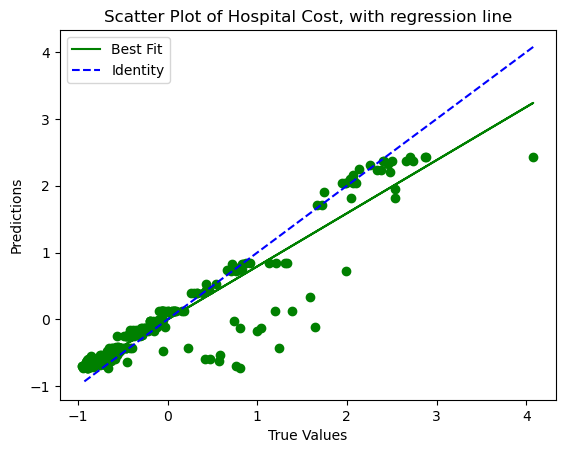

In [193]:
plt.scatter(x=y_test_scaled, y=y_pred, color='g') # Plot scatter plot with regression line
a, b = np.polyfit(y_test_scaled[:,0], y_pred, 1)
plt.plot(y_test_scaled, a * y_test_scaled + b, "g-", label="Best Fit")
p1 = max(max(y_pred), max(y_test_scaled))
p2 = min(min(y_pred), min(y_test_scaled))
plt.plot([p1, p2], [p1, p2], "b--", label="Identity")
plt.title('Scatter Plot of Hospital Cost, with regression line')
plt.ylabel("Predictions")
plt.xlabel("True Values")
plt.legend()
plt.show()

The best fit line still lies near to the identity line, meaning the trend of the identity is being closely followed.

In [113]:
# Use permutation importance to get feature importances from HGBR
result = permutation_importance(final_HGBR, X_test_scaled, y_test_scaled, n_repeats=10, random_state=42)

feature_importances = result.importances_mean # Get feature importances

# Map feature importances to their corresponding feature names
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Print feature importances
print("Feature Importances:")
for feature, importance in feature_importance_dict.items():
    print(f"{feature}: {importance:.4f}")

Feature Importances:
Age: 0.1559
BMI: 0.2406
dummy_smoker: 1.2603
encoded_northeast: 0.0006
encoded_southwest: -0.0002


I used permutation importance to get the feature importances from Histogram Gradient Boosting Regressor where values that are greater is more important. Therefore, this shows that dummy_smoker plays the most importance in the model while encoded_southwest played the least.